In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import null_space

In [2]:
Sigma_x = np.matrix([[0, 1], [1, 0]])
Sigma_y = np.matrix([[0, -1j], [1j, 0]])
Sigma_z = np.matrix([[1, 0], [0, -1]])
Sigma_plus = (Sigma_x +1j*Sigma_y)/2
Sigma_minus = Sigma_plus.getH()

In [3]:
def Enlarge_Matrix_site_j(j, N, matrix):
    # I⊗...⊗I⊗M⊗I...⊗I: Convert local operators into global operators.
    # j: site, starts in 0.
    
    M = np.eye(len(matrix))
    if j == 0: M = matrix
    
    for i in range(1,N):
        if i == j: M = np.kron(M, matrix)
        else: M = np.kron(M, np.eye(len(matrix)))        

    return M

def Correlation_Matrix_i_Matrix_j(i,j,N,matrix_i, matrix_j):
    # I⊗...⊗I⊗M⊗I...⊗I⊗M⊗I⊗I...⊗I

    M = np.eye(len(matrix_i))
    
    if j == 0: M = matrix_j
    elif i == 0: M = matrix_i
    
    for k in range(1,N):
        if k == j: M = np.kron(M, matrix_j)
        elif k == i: M = np.kron(M, matrix_i)
        else: M = np.kron(M, np.eye(len(matrix_i)))        

    return M

def S_Term(N, cte_list, SigmaMatrix):
    # I⊗...⊗I⊗ΔSigma⊗Sigma⊗I...⊗I: Sigma can be Sigmax, Sigmay or Sigmaz.
    # cte_list = [cte_L, cte_M, cte_R], can be J or ∆.

    Matrix_Sigma = np.zeros((2**N, 2**N))

    cte_L = cte_list[0]
    cte_M = cte_list[1]
    cte_R = cte_list[2]    
    
    for i in range(0,N-1):
        M = np.eye(len(SigmaMatrix))
        
        if i == 0: M = SigmaMatrix
       
        for j in range(1,N):
            if j == i or j == i + 1: M = np.kron(M, SigmaMatrix)
            else: M = np.kron(M, np.eye(len(SigmaMatrix)))        

        if i < N/2 - 1: cte = cte_L
        elif i > N/2 - 1: cte = cte_R
        else: cte = cte_M

        Matrix_Sigma = Matrix_Sigma + M*cte #cte can be ∆_i or J_i

    return Matrix_Sigma #∑ I⊗...⊗I⊗ΔSigma⊗Sigma⊗I...⊗I


def Build_Hamiltonian(N, delta_list, J_list):
    # H = ∑ I⊗...⊗I⊗JSx⊗Sx⊗I...⊗I + I⊗...⊗I⊗JSy⊗Sy⊗I...⊗I + I⊗...⊗I⊗ΔSz⊗Sz⊗I...⊗I
    global Sigma_x, Sigma_y, Sigma_z
    
    H = S_Term(N, J_list, Sigma_x) + S_Term(N, J_list, Sigma_y) + S_Term(N, delta_list, Sigma_z)

    return H    

#Functions from article:
def Liouvillian(H, Ls, hbar = 1):
    d = len(H) # dimension of the system
    superH = -1j/hbar * ( np.kron(np.eye(d),H)-np.kron(H.T,np.eye(d)) ) # Hamiltonian part
    superL = sum([np.kron(L.conjugate(),L) 
                  - 1/2 * ( np.kron(np.eye(d),L.conjugate().T.dot(L)) +
                            np.kron(L.T.dot(L.conjugate()),np.eye(d)) 
                          ) for L in Ls])
    return superH + superL

In [6]:
N = 4

deltaL_over_JL_values = np.linspace(-8,8,30) #(∆_L/J_L)

Currents_reverse_N4 = np.array([])
Currents_forward_N4 = np.array([])

for value in deltaL_over_JL_values: #(∆_L/J_L)SS
    
    J_list = [1,1,1] #J_L = J_R = J_M = 1
    delta_list = [value*J_list[0],0,0] # ∆_L = (∆_L/J_L)*J_L
    
    H = Build_Hamiltonian(N, delta_list, J_list)

    #Current from right to left (Reverse Bias)
    lambda_1 = 0
    lambda_N = 0.5
        
    L_K = [np.sqrt(lambda_1)*Enlarge_Matrix_site_j(0, N, Sigma_plus),  
           np.sqrt(1 - lambda_1)*Enlarge_Matrix_site_j(0, N, Sigma_minus), 
           np.sqrt(lambda_N)*Enlarge_Matrix_site_j(N-1, N, Sigma_plus), 
           np.sqrt(1 - lambda_N)*Enlarge_Matrix_site_j(N-1, N, Sigma_minus)]

    Superoperator = Liouvillian(H, L_K)

    null = null_space(Superoperator)
    rho_ss = np.reshape(null, H.shape ) 
    rho_ss = rho_ss/np.trace(rho_ss)

    k = 0 #site to calculate current
    Current_operator = 2*J_list[k]*(Correlation_Matrix_i_Matrix_j(k,k+1,N,Sigma_x, Sigma_y) - Correlation_Matrix_i_Matrix_j(k,k+1,N,Sigma_y, Sigma_x))
    Current = np.trace(Current_operator@rho_ss)
    Currents_reverse_N4 = np.append(Currents_reverse_N4, Current)

    #Current from left to right (Forward Bias)
    lambda_1 = 0.5
    lambda_N = 0.0
        
    L_K = [np.sqrt(lambda_1)*Enlarge_Matrix_site_j(0, N, Sigma_plus),  
           np.sqrt(1 - lambda_1)*Enlarge_Matrix_site_j(0, N, Sigma_minus), 
           np.sqrt(lambda_N)*Enlarge_Matrix_site_j(N-1, N, Sigma_plus), 
           np.sqrt(1 - lambda_N)*Enlarge_Matrix_site_j(N -1, N, Sigma_minus)]

    Superoperator = Liouvillian(H, L_K)

    null = null_space(Superoperator)
    rho_ss = np.reshape(null, H.shape ) 
    rho_ss = rho_ss/np.trace(rho_ss)

    k = 0 #site to calculate current
    Current_operator = 2*J_list[k]*(Correlation_Matrix_i_Matrix_j(k,k+1,N,Sigma_x, Sigma_y) - Correlation_Matrix_i_Matrix_j(k,k+1,N,Sigma_y, Sigma_x))
    Current = np.trace(Current_operator@rho_ss)
    Currents_forward_N4 = np.append(Currents_forward_N4, Current)

In [7]:
N = 6

deltaL_over_JL_values = np.linspace(-8,8,30) #(∆_L/J_L)

Currents_reverse_N6 = np.array([])
Currents_forward_N6 = np.array([])

for value in deltaL_over_JL_values: #(∆_L/J_L)SS
    
    J_list = [1,1,1] #J_L = J_R = J_M = 1
    delta_list = [value*J_list[0],0,0] # ∆_L = (∆_L/J_L)*J_L
    
    H = Build_Hamiltonian(N, delta_list, J_list)

    #Current from right to left (Reverse Bias)
    lambda_1 = 0
    lambda_N = 0.5
        
    L_K = [np.sqrt(lambda_1)*Enlarge_Matrix_site_j(0, N, Sigma_plus),  
           np.sqrt(1 - lambda_1)*Enlarge_Matrix_site_j(0, N, Sigma_minus), 
           np.sqrt(lambda_N)*Enlarge_Matrix_site_j(N-1, N, Sigma_plus), 
           np.sqrt(1 - lambda_N)*Enlarge_Matrix_site_j(N-1, N, Sigma_minus)]

    Superoperator = Liouvillian(H, L_K)

    null = null_space(Superoperator)
    rho_ss = np.reshape(null, H.shape ) 
    rho_ss = rho_ss/np.trace(rho_ss)

    k = 0 #site to calculate current
    Current_operator = 2*J_list[k]*(Correlation_Matrix_i_Matrix_j(k,k+1,N,Sigma_x, Sigma_y) - Correlation_Matrix_i_Matrix_j(k,k+1,N,Sigma_y, Sigma_x))
    Current = np.trace(Current_operator@rho_ss)
    Currents_reverse_N6 = np.append(Currents_reverse_N6, Current)

    #Current from left to right (Forward Bias)
    lambda_1 = 0.5
    lambda_N = 0.0
        
    L_K = [np.sqrt(lambda_1)*Enlarge_Matrix_site_j(0, N, Sigma_plus),  
           np.sqrt(1 - lambda_1)*Enlarge_Matrix_site_j(0, N, Sigma_minus), 
           np.sqrt(lambda_N)*Enlarge_Matrix_site_j(N-1, N, Sigma_plus), 
           np.sqrt(1 - lambda_N)*Enlarge_Matrix_site_j(N -1, N, Sigma_minus)]

    Superoperator = Liouvillian(H, L_K)

    null = null_space(Superoperator)
    rho_ss = np.reshape(null, H.shape ) 
    rho_ss = rho_ss/np.trace(rho_ss)

    k = 0 #site to calculate current
    Current_operator = 2*J_list[k]*(Correlation_Matrix_i_Matrix_j(k,k+1,N,Sigma_x, Sigma_y) - Correlation_Matrix_i_Matrix_j(k,k+1,N,Sigma_y, Sigma_x))
    Current = np.trace(Current_operator@rho_ss)
    Currents_forward_N6 = np.append(Currents_forward_N6, Current)

In [5]:
deltaL_over_JL_values = np.loadtxt("Figures and txt/deltaL_over_JL_values.txt")
Currents_forward_N4 = np.loadtxt("Figures and txt/Currents_forward_N4.txt", dtype=np.complex_)
Currents_reverse_N4 = np.loadtxt("Figures and txt/Currents_reverse_N4.txt", dtype=np.complex_)
Currents_forward_N6 = np.loadtxt("Figures and txt/Currents_forward_N6.txt", dtype=np.complex_)
Currents_reverse_N6 = np.loadtxt("Figures and txt/Currents_reverse_N6.txt", dtype=np.complex_)

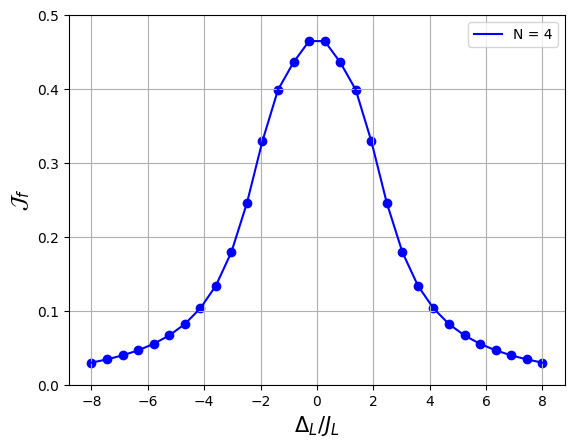

In [5]:
plt.plot(deltaL_over_JL_values, np.abs(Currents_forward_N4), label = "N = 4", color = "blue")
plt.plot(deltaL_over_JL_values, np.abs(Currents_forward_N6), label = "N = 6", color = "red")
plt.scatter(deltaL_over_JL_values, np.abs(Currents_forward_N4), color = "blue")
plt.scatter(deltaL_over_JL_values, np.abs(Currents_forward_N6), color = "red")
plt.xlabel(r"$\Delta_{L} / J_{L}$", fontsize = 15)
plt.ylabel(r"$\mathcal{J}_{f}$", fontsize = 15)
plt.legend()
plt.ylim(0,0.5)
plt.grid()
#plt.savefig("J_f.png", dpi = 300)

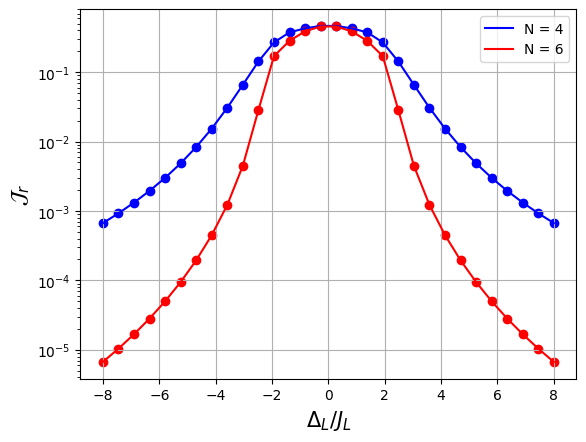

In [8]:
plt.plot(deltaL_over_JL_values, np.abs(Currents_reverse_N4), label = "N = 4", color = "blue")
plt.plot(deltaL_over_JL_values, np.abs(Currents_reverse_N6), label = "N = 6", color = "red")
plt.scatter(deltaL_over_JL_values, np.abs(Currents_reverse_N4), color = "blue")
plt.scatter(deltaL_over_JL_values, np.abs(Currents_reverse_N6), color = "red")

plt.yscale("log")
plt.xlabel(r"$\Delta_{L} / J_{L}$", fontsize = 15)
plt.ylabel(r"$\mathcal{J}_{r}$", fontsize = 15)
plt.legend()
plt.grid()
#plt.savefig("J_r.png", dpi = 300)

In [9]:
R_N4 =  -Currents_forward_N4/Currents_reverse_N4
C_N4 = np.abs((Currents_forward_N4+Currents_reverse_N4)/(Currents_forward_N4-Currents_reverse_N4))

R_N6 =  -Currents_forward_N6/Currents_reverse_N6
C_N6 = np.abs((Currents_forward_N6+Currents_reverse_N6)/(Currents_forward_N6-Currents_reverse_N6))

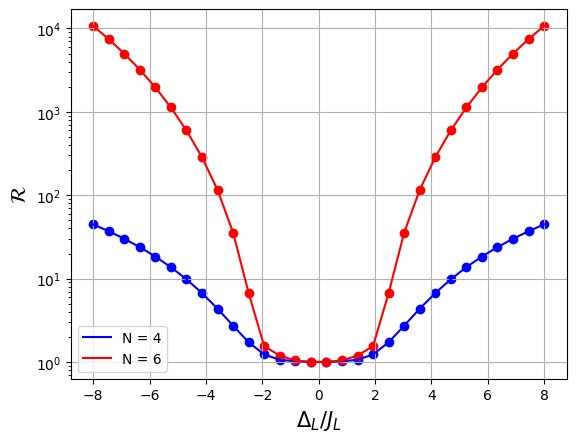

In [10]:
plt.plot(deltaL_over_JL_values, R_N4, label = "N = 4", color = "blue")
plt.plot(deltaL_over_JL_values, R_N6, label = "N = 6", color = "red")
plt.scatter(deltaL_over_JL_values, R_N4, color = "blue")
plt.scatter(deltaL_over_JL_values, R_N6, color = "red")
plt.yscale("log")
plt.xlabel(r"$\Delta_{L} / J_{L}$", fontsize = 15)
plt.ylabel(r"$\mathcal{R}$", fontsize = 15)
plt.legend()
plt.grid()
#plt.savefig("R.png", dpi = 300)

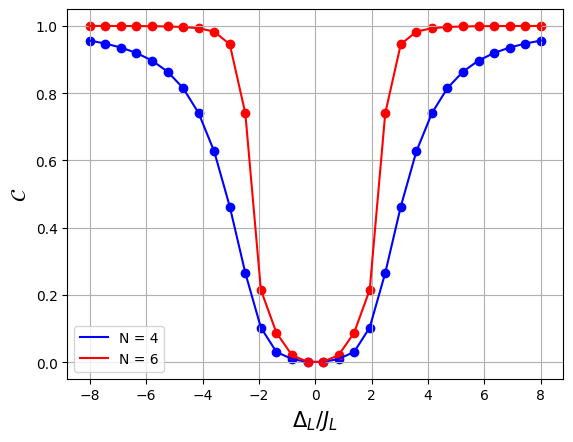

In [11]:
plt.plot(deltaL_over_JL_values, C_N4, label = "N = 4", color = "blue")
plt.plot(deltaL_over_JL_values, C_N6, label = "N = 6", color = "red")
plt.scatter(deltaL_over_JL_values, C_N4, color = "blue")
plt.scatter(deltaL_over_JL_values, C_N6, color = "red")
plt.xlabel(r"$\Delta_{L} / J_{L}$", fontsize = 15)
plt.ylabel(r"$\mathcal{C}$", fontsize = 15)
plt.legend()
plt.grid()
#plt.savefig("C.png", dpi = 300)